#### Use glob to get the files list

In [2]:
cd CLAMS/

C:\Users\Ma\PY\Pandas\CLAMS


In [3]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
files = glob.glob('2018*.csv')
files

['2018-04-09.0101.CSV',
 '2018-04-09.0102.CSV',
 '2018-04-09.0103.CSV',
 '2018-04-09.0104.CSV',
 '2018-04-09.0105.CSV',
 '2018-04-09.0106.CSV',
 '2018-04-09.0111.CSV',
 '2018-04-09.0112.CSV',
 '2018-04-09.0113.CSV',
 '2018-04-09.0114.CSV',
 '2018-04-09.0115.CSV',
 '2018-04-09.0116.CSV']

#### Extract and store sample name, chamber, and genotype to a dataframe

In [18]:
sample_info = pd.DataFrame(columns=['cage', 'mouse_id', 'mass'], dtype=np.float64)

for f in files:
    content = open(f).read()
    cage = re.findall('Group\/Cage\D+([0-9]+)\n', content)[0]
    mouse_id = re.findall('Subject ID\D+([0-9]+)\n', content)[0]
    mass = re.findall('Subject Mass\D+([0-9.]+)', content)[0]
    
    #Creat a temporal dataframe for new sample and append it to sampel_info dataframe
    new = pd.DataFrame({'cage': cage, 'mouse_id': mouse_id,'mass': float(mass) }, index=['info'])
    sample_info = sample_info.append(new, ignore_index=True)

In [19]:
#define a mapping function to determine genotype
def genotyping(mouse):
    if mouse in ['1399','1390','1403','1377','1386','1373']: 
        return 'WT'
    if mouse in ['1375','1400','1391','1392','1417','1433']:
        return 'KO'

In [20]:
sample_info['genotype'] = sample_info['mouse_id'].map(genotyping)
sample_info

,cage,mouse_id,mass,genotype
0,0101,1403,49.30,WT
1,0102,1375,42.25,KO
2,0103,1399,42.40,WT
3,0104,1391,40.78,KO
4,0105,1377,46.80,WT
5,0106,1392,35.40,KO
6,0111,1386,48.39,WT
7,0112,1400,43.81,KO
8,0113,1390,41.75,WT
9,0114,1417,31.29,KO


#### Read CLAMS csv and concat them into a dataframe

In [21]:
#read csv with date_parser and skip descriptional data
#nrow: the rows to be read, 
#316 (total rows with valid data in each sample) - 24 (skipped rows) -1 (header)
csv_list = []
for csv in files:
    csv = pd.read_csv(csv,  
                  skiprows=([i for i in range(22)] + [23,24]), parse_dates=['DATE/TIME'],
                  dtype={'CHAN': str, 'VO2': np.float64, 'VCO2': np.float64})
    csv_list.append(csv)
df = pd.concat(csv_list, ignore_index=True)
df.dtypes

INTERVAL                      object
CHAN                          object
DATE/TIME             datetime64[ns]
VO2                          float64
O2IN                         float64
O2OUT                        float64
DO2                          float64
ACCO2                        float64
VCO2                         float64
CO2IN                        float64
CO2OUT                       float64
DCO2                         float64
ACCCO2                       float64
RER                          float64
HEAT                         float64
FLOW                         float64
STATUS1                       object
FEED1                        float64
FEED1 ACC                    float64
XTOT                         float64
XAMB                         float64
YTOT                         float64
YAMB                         float64
ZTOT                         float64
ENCLOSURE TEMP               float64
ENCLOSURE SETPOINT           float64
Unnamed: 26                  float64
d

In [22]:
df.groupby('CHAN').size()

CHAN
0101    292
0102    292
0103    292
0104    292
0105    292
0106    292
0111    292
0112    292
0113    292
0114    292
0115    292
0116    292
dtype: int64

#### Data Cleaning

In [23]:
df.dropna(subset=['DATE/TIME'], inplace=True)

In [24]:
df = df[df.VO2 != 0]

In [25]:
df.groupby('CHAN').size()

CHAN
0101    292
0102    292
0103    292
0104    291
0105    291
0106    291
0111    291
0112    291
0113    291
0114    291
0115    291
0116    291
dtype: int64

#### Down-size dataframe to only include VO2 and VCO2, the two columns to be analyzed

In [26]:
df = df[['INTERVAL', 'CHAN', 'DATE/TIME', 'VO2', 'VCO2']]
df = df.rename(columns={'INTERVAL':'interval','CHAN':'cage','DATE/TIME':'date'})
df.head()

,interval,cage,date,VO2,VCO2
0,1,0101,2018-04-09 16:33:45,2911.0,2207.0
1,2,0101,2018-04-09 16:46:45,2557.0,1928.0
2,3,0101,2018-04-09 17:00:45,3085.0,2362.0
3,4,0101,2018-04-09 17:13:45,2745.0,2121.0
4,5,0101,2018-04-09 17:27:45,1756.0,1306.0


#### Merge sample_info and df together

In [27]:
mdf = pd.merge(df, sample_info, on='cage')
mdf.tail()

,interval,cage,date,VO2,VCO2,mouse_id,mass,genotype
3490,287,0116,2018-04-12 09:06:45,2904.0,2332.0,1433,33.2,KO
3491,288,0116,2018-04-12 09:19:45,3100.0,2640.0,1433,33.2,KO
3492,289,0116,2018-04-12 09:33:45,2154.0,1783.0,1433,33.2,KO
3493,290,0116,2018-04-12 09:46:45,2421.0,1965.0,1433,33.2,KO
3494,291,0116,2018-04-12 10:00:45,2622.0,2005.0,1433,33.2,KO


#### Add timedelta column

In [28]:
def timedelta(group):
    for i in group:
        return group-i

In [29]:
mdf['time_hr'] = mdf.groupby('mouse_id').date.apply(timedelta) 

In [30]:
mdf.tail()

,interval,cage,date,VO2,VCO2,mouse_id,mass,genotype,time_hr
3490,287,0116,2018-04-12 09:06:45,2904.0,2332.0,1433,33.2,KO,2 days 16:21:00
3491,288,0116,2018-04-12 09:19:45,3100.0,2640.0,1433,33.2,KO,2 days 16:34:00
3492,289,0116,2018-04-12 09:33:45,2154.0,1783.0,1433,33.2,KO,2 days 16:48:00
3493,290,0116,2018-04-12 09:46:45,2421.0,1965.0,1433,33.2,KO,2 days 17:01:00
3494,291,0116,2018-04-12 10:00:45,2622.0,2005.0,1433,33.2,KO,2 days 17:15:00


#### Time series resampling with freqency 'Hr'

In [31]:
time_key = pd.Grouper(freq='H')

result = mdf.set_index('time_hr').groupby(['genotype', time_key]).mean()

result.reset_index(inplace=True)

result['time_hr'] = result['time_hr'] // np.timedelta64(1, 'h')

In [32]:
result.tail()

,genotype,time_hr,VO2,VCO2,mass
127,WT,61,2482.916667,1917.708333,45.931667
128,WT,62,2691.708333,2074.458333,45.931667
129,WT,63,2354.500000,1803.466667,45.931667
130,WT,64,2039.583333,1549.666667,45.931667
131,WT,65,2122.785714,1635.357143,45.920000


#### Plotting

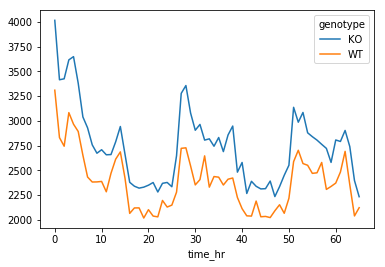

In [33]:
result.pivot_table(index='time_hr', columns='genotype', values='VO2').plot()

#### Fine tuning time window

In [34]:
def subset(group, head, tail):
    group = group[head+1:][:-tail]
    group['time_hr'] -= group['time_hr'].values[0]
    return group

In [35]:
truc_result = result.groupby('genotype', group_keys=False).apply(subset, head=4, tail=2)
truc_result.head()

,genotype,time_hr,VO2,VCO2,mass
5,KO,0,3380.416667,2569.666667,37.788333
6,KO,1,3039.533333,2283.433333,37.788333
7,KO,2,2929.375000,2232.875000,37.788333
8,KO,3,2757.208333,2105.458333,37.788333
9,KO,4,2672.933333,2012.233333,37.788333


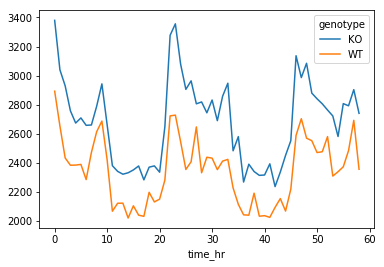

In [36]:
truc_result.pivot_table(index='time_hr', columns='genotype',values='VO2').plot()